In [1]:
import sys
sys.path.append('../..')

In [2]:
from DLBio import pt_training
import ds_cifar
from torchvision.models.mobilenet import mobilenet_v2
import torch.nn as nn
from DLBio.pytorch_helpers import get_device, get_num_params
from DLBio.helpers import check_mkdir
from DLBio.pt_train_printer import Printer
import json
import matplotlib.pyplot as plt
from os.path import join

In [3]:
class Classification(pt_training.ITrainInterface):
    def __init__(self, model, device):
        self.model = model
        self.xent_loss = nn.CrossEntropyLoss()
        self.metrics = {
            'acc': accuracy
        }
        self.d = device

    def train_step(self, sample):
        images, targets = sample[0].to(self.d), sample[1].to(self.d)
        pred = self.model(images)

        loss = self.xent_loss(pred, targets)
        metrics = dict()

        metrics.update({k: v(pred, targets) for k, v in self.metrics.items()})

        return loss, metrics


def accuracy(y_pred, y_true):
    _, y_pred = y_pred.max(1)  # grab class predictions
    return (y_pred == y_true).float().mean().item()


In [4]:
# define constants
FOLDER = './class_sample'
BATCH_SIZE = 32
NUM_WORKERS = 4 # set to zero, if you want to run a debugger
OPT_TYPE = 'Adam'
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.00001
EPOCHS = 9
LR_STEPS = 3
DO_EARLY_STOPPING = True
STOP_AFTER = 10
ES_METRIC = 'val_acc'
SAVE_INTERVALL = -1
PRINT_FREQUENCY = 500 # print every 500 batches
SEED = 0

# use seeds to ensure comparable results ()
pt_training.set_random_seed(SEED)

Setting seed: 0


<function DLBio.pt_training.set_random_seed.<locals>._init_fn(worker_id)>

In [7]:
device = get_device()
print(device)
model = mobilenet_v2(pretrained=True)
# cifar only has 10 classes
model = model.to(device)
#model = model.to('cuda:0')

cuda:0
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /nfshome/lentzsch/.cache/torch/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 15.3MB/s]


In [8]:


check_mkdir(FOLDER, is_dir=True)
model_out = join(FOLDER, 'model.pt')
log_file = join(FOLDER, 'log.json')

# write some model specs
with open(join(FOLDER, 'model_specs.json'), 'w') as file:
    json.dump({
        'num_trainable': float(get_num_params(model, True)),
        'num_params': float(get_num_params(model, False))
    }, file)

dl_train = ds_cifar.get_dataloader(
            is_train=True,
            batch_size=BATCH_SIZE,
            num_workers=NUM_WORKERS
        )

dl_test = ds_cifar.get_dataloader(
            is_train=False,
            batch_size=BATCH_SIZE,
            num_workers=NUM_WORKERS
        )

optimizer = pt_training.get_optimizer(
        'Adam', model.parameters(),
        LEARNING_RATE,
        weight_decay=WEIGHT_DECAY
    )

if LR_STEPS > 0:
    scheduler = pt_training.get_scheduler(
            LR_STEPS, EPOCHS, optimizer)

if DO_EARLY_STOPPING:
    assert SAVE_INTERVALL == -1
    early_stopping = pt_training.EarlyStopping(
            ES_METRIC, get_max=True, epoch_thres=STOP_AFTER
        )
else:
    early_stopping = None
    
train_interface = Classification(model, device)

training = pt_training.Training(
        optimizer, dl_train, train_interface,
        scheduler=scheduler, printer=Printer(PRINT_FREQUENCY, log_file),
        save_path=model_out, save_steps=SAVE_INTERVALL,
        val_data_loader=dl_test,
        early_stopping=early_stopping
    )

training(EPOCHS)

Files already downloaded and verified
Files already downloaded and verified
Sched step size: 3
Ep: 0, loss: 0.86488 acc: 0.728 lr: 0.00100 sec: 54.19
Ep: 0, loss: 0.70981 acc: 0.773 lr: 0.00100 sec: 108.60
Ep: 0, loss: 0.64179 acc: 0.792 lr: 0.00100 sec: 164.31
Ep: 0, loss: 0.63526 acc: 0.793 lr: 0.00100 sec: 171.28
saving model: ./class_sample/model.pt
Ep: 0, val_loss: 0.45800 val_acc: 0.850 lr: -1.00000 sec: 11.39
Ep: 1, loss: 0.41221 acc: 0.860 lr: 0.00100 sec: 56.01
Ep: 1, loss: 0.41639 acc: 0.860 lr: 0.00100 sec: 112.41
Ep: 1, loss: 0.41038 acc: 0.861 lr: 0.00100 sec: 169.18
Ep: 1, loss: 0.40980 acc: 0.862 lr: 0.00100 sec: 176.24
saving model: ./class_sample/model.pt
Ep: 1, val_loss: 0.36884 val_acc: 0.872 lr: -1.00000 sec: 11.29
Ep: 2, loss: 0.35415 acc: 0.881 lr: 0.00100 sec: 56.51
Ep: 2, loss: 0.35578 acc: 0.881 lr: 0.00100 sec: 112.59
Ep: 2, loss: 0.35758 acc: 0.880 lr: 0.00100 sec: 168.62
Ep: 2, loss: 0.35719 acc: 0.880 lr: 0.00100 sec: 175.73
Ep: 2, val_loss: 0.38995 val_acc

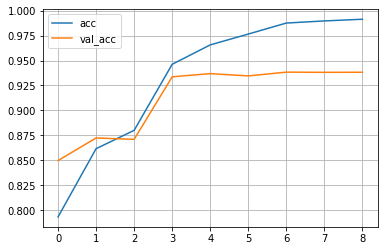

In [9]:
with open(log_file, 'r') as file:
    log = json.load(file)

plt.plot(log['acc'], label='acc')
plt.plot(log['val_acc'], label='val_acc')

plt.legend()
plt.grid()